In [1]:
%cd ..

/Users/erwan/Programmes/2022 Datacamp/solar_wind/src


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from display import plot_event, multiple_plots, display_timeline, show_densities
from problem import get_train_data
from problem import turn_prediction_to_event_list


In [3]:
data_train, labels_train = get_train_data()
events = turn_prediction_to_event_list(labels_train)
no_events = turn_prediction_to_event_list(labels_train == 0)

In [4]:
var_name = 'Beta'
df = data_train[['Beta']].copy()
df['label'] = labels_train.copy()

var_s = data_train['Beta'].copy()
var_s[var_s > 500] = 500 # Cas particulier de Beta qui présente une valeur à 14 000... 

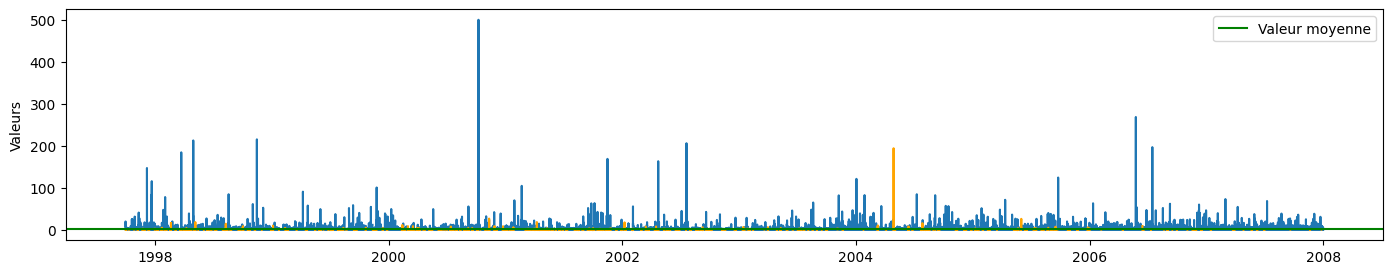

In [5]:
display_timeline(var_s, labels_train)

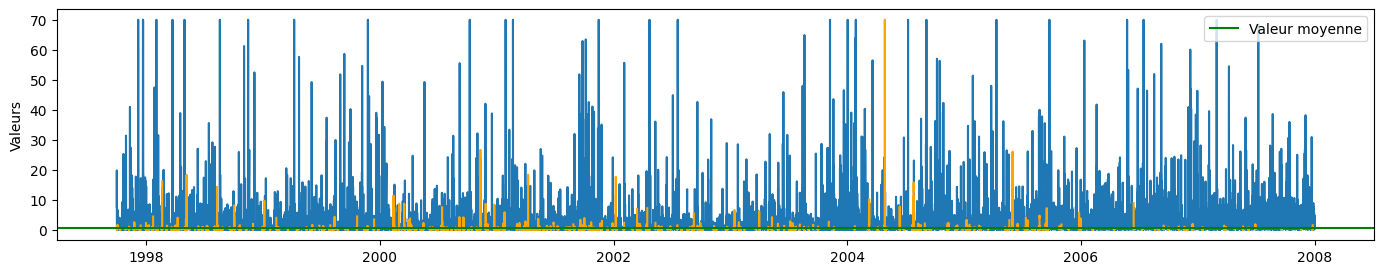

In [6]:
thresh_beta_s = var_s.map(lambda x: min(x, 70))
display_timeline(thresh_beta_s, labels_train)

#### Histogramme valeurs par classe

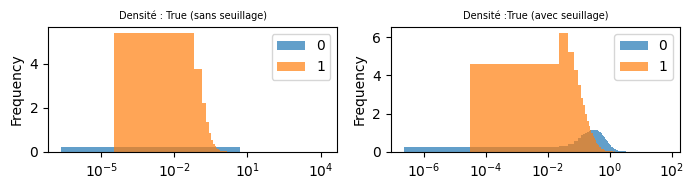

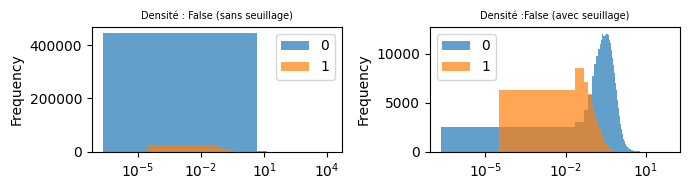

In [7]:
# Affichage des densités
threshold_df = thresh_beta_s.to_frame()
threshold_df['label'] = labels_train

for density in [True, False]:
    _, ax = plt.subplots(ncols=2, figsize=(7, 2))
    ax[0].set_title("Densité : " + str(density) + " (sans seuillage)", fontsize=7)
    ax[1].set_title("Densité :" + str(density)+ " (avec seuillage)", fontsize=7)

    df.groupby(['label'])['Beta'].plot(kind='hist', alpha=0.7, ax=ax[0], legend=True, density=density, logx=True, bins=3000)
    threshold_df.groupby(['label'])['Beta'].plot(kind='hist', alpha=0.7, ax=ax[1], legend=True, density=density, logx=True, bins=3000)
    plt.tight_layout()

#### Distribution par la classe 

In [8]:
seuil = 50
storm_brut_s = data_train[labels_train == 1]['Beta'].copy().map(lambda x: min(x, seuil))
storm_small_avg_s = storm_brut_s.rolling('30 min', center=True).mean()
storm_long_avg_s = storm_brut_s.rolling('24 h', center=True).mean()

calm_brut_s = data_train[labels_train == 0]['Beta'].copy().map(lambda x: min(x, seuil))
calm_small_avg_s = calm_brut_s.rolling('30 min', center=True).mean()
calm_long_avg_s = calm_brut_s.rolling('24 h', center=True).mean()

<AxesSubplot: >

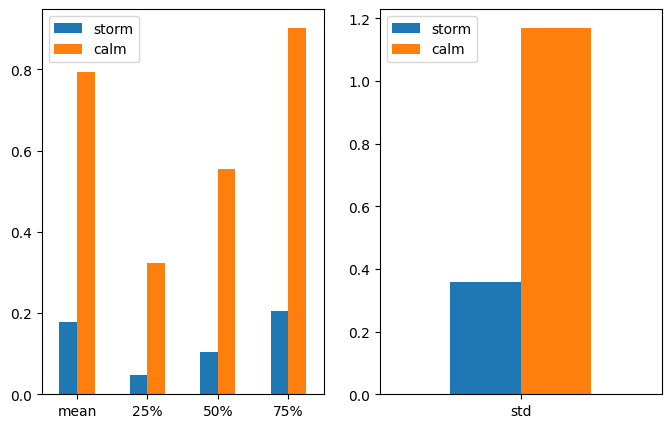

In [9]:
drop_cols, snd_ax_cols = ['count', 'max', 'min'], ['std']

index_ax_1 = storm_small_avg_s.describe().drop(drop_cols + snd_ax_cols).index
index_ax_2 = storm_small_avg_s.describe()[snd_ax_cols].index

df = pd.DataFrame({'storm':  storm_small_avg_s.describe(),
                   'calm': calm_small_avg_s.describe()}, index=index_ax_1)

std_df = pd.DataFrame({'storm': storm_small_avg_s.describe(),
                   'calm': calm_small_avg_s.describe()}, index=index_ax_2)

_, axs = plt.subplots(1, 2, figsize=(8, 5))
df.plot.bar(rot=0, ax=axs[0])
std_df.plot.bar(rot=0, ax=axs[1])

#### Observation durée moyenne avant retour à des valeurs de temps calme

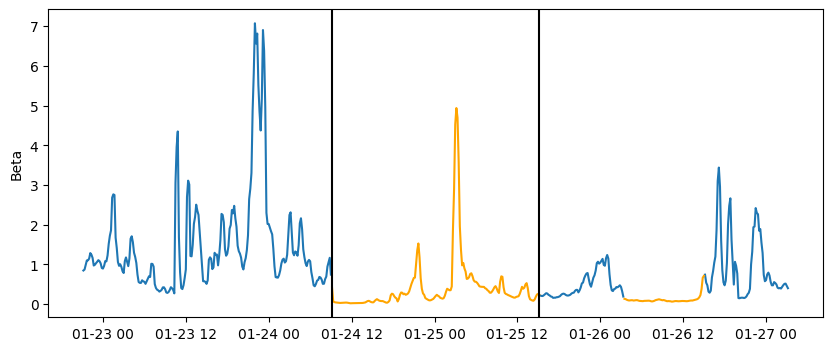

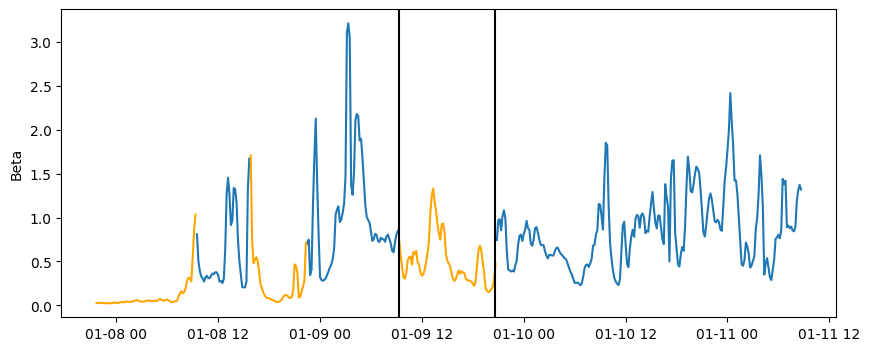

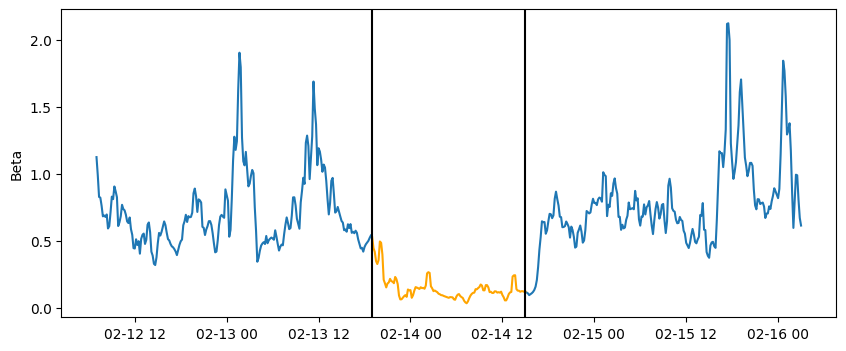

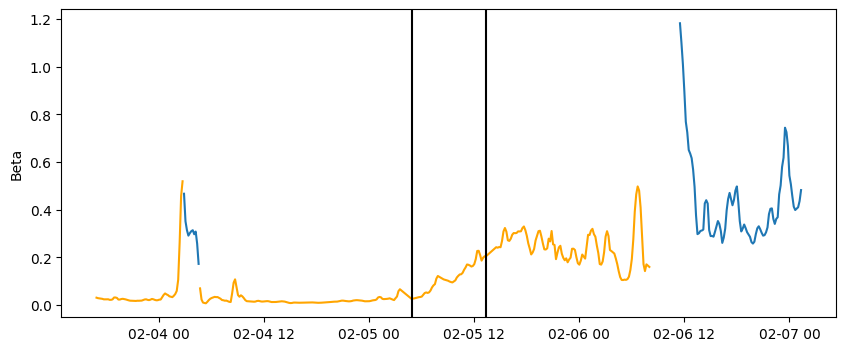

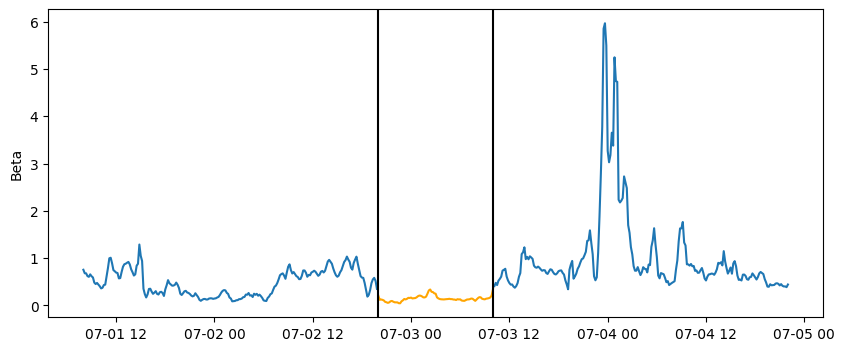

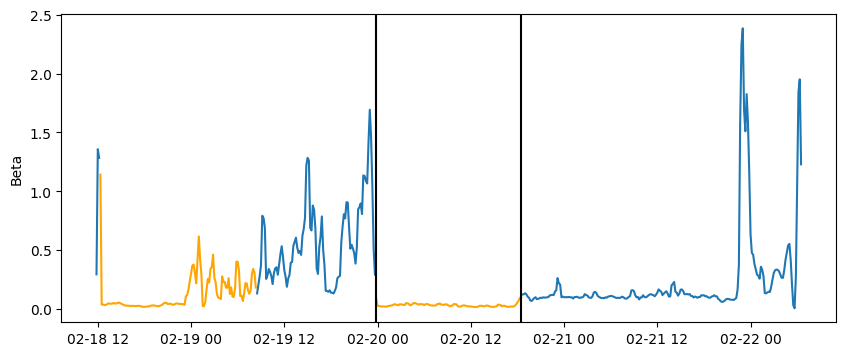

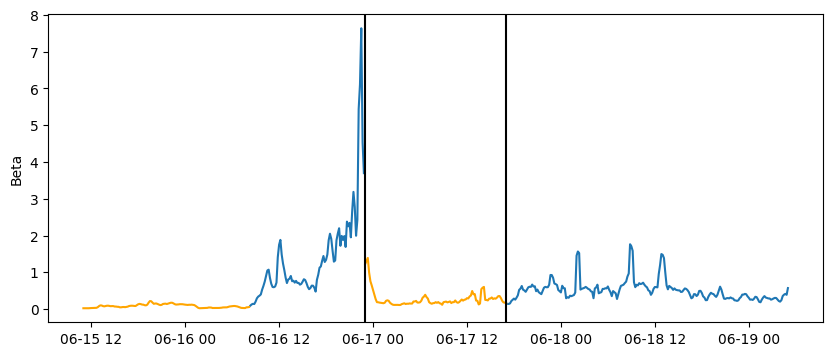

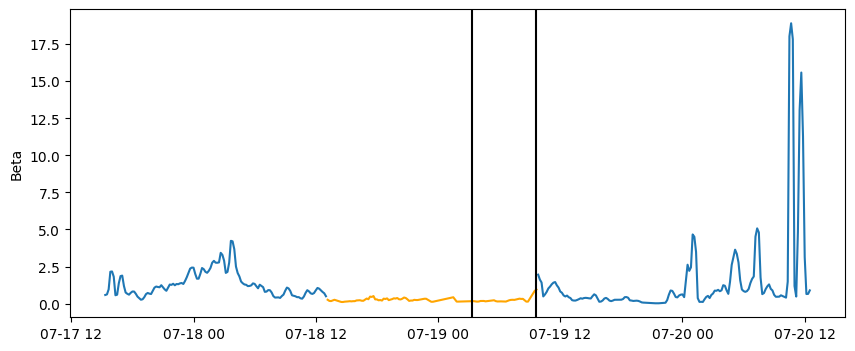

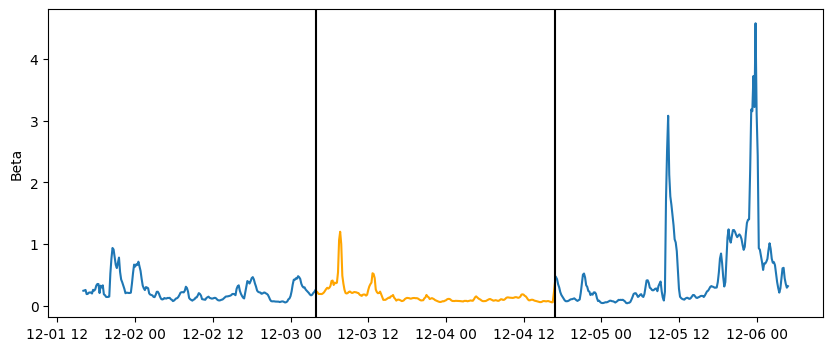

In [10]:
seuil = 50
delta = 36 # heures
var_s = data_train['Beta'].copy().map(lambda x: min(x, seuil))
var_s = var_s.rolling('30 min', center=True).mean()


multiple_plots(
    var_s.to_frame(), 
    labels_train, 
    n_events=9, 
    events=events,
    delta=36,
    figsize=(10, 4),
    random_state=2
    )

#### Stationnarité, ARMA et ..

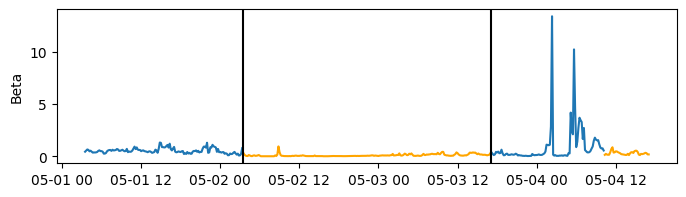

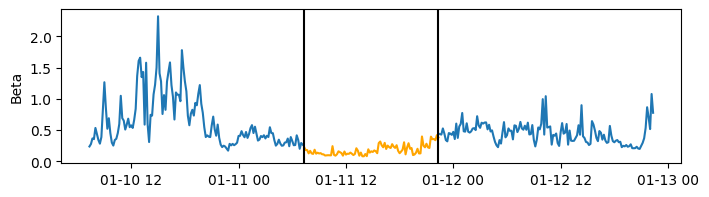

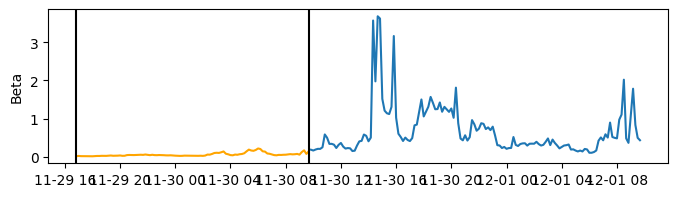

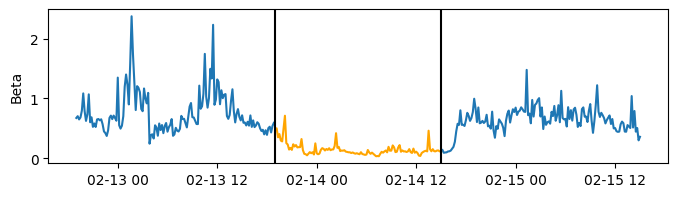

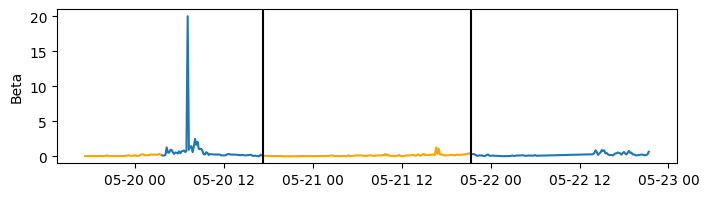

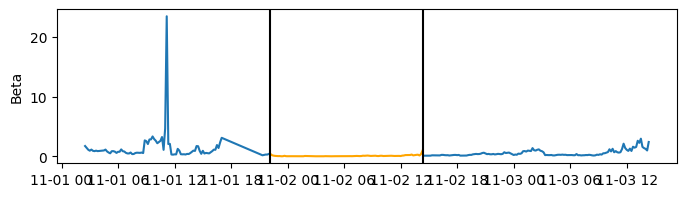

In [11]:
multiple_plots(
    data=thresh_beta_s.to_frame(), 
    labels=labels_train,
    n_events=6, 
    events=events, 
    delta=24, 
    figsize=(8, 2))

In [12]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

In [13]:
hours = 6
day = hours * 24 
week = day * 7

n_iter = 3 * day
start = 5000

frac_beta_s = thresh_beta_s.iloc[start:start + n_iter]
frac_label = labels_train[start:start + n_iter]

In [14]:
frac_beta_s.index[0], frac_beta_s.index[-1] 

(Timestamp('1997-11-06 00:50:00'), Timestamp('1997-11-09 00:50:00'))

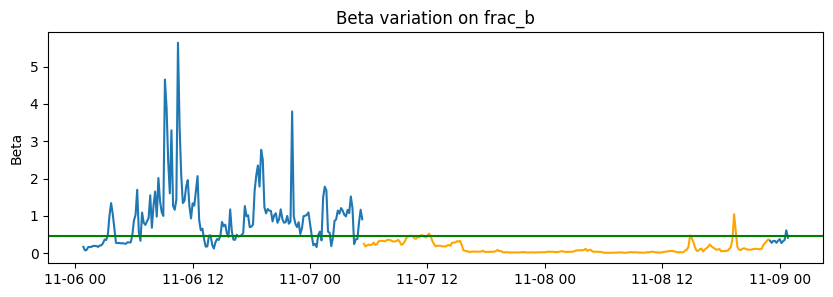

In [15]:
l = 0.1
low = np.ma.masked_where(frac_label, frac_beta_s)
high = np.ma.masked_where(frac_label < l, frac_beta_s)
# print('Max of the subset for ', col, subset[col].max())

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title('Beta variation on frac_b')
ax.set_ylabel('Beta')

ax.plot(frac_beta_s.index, low)
ax.plot(frac_beta_s.index, high, color='orange')
ax.axhline(y=frac_beta_s.mean(), color='g')

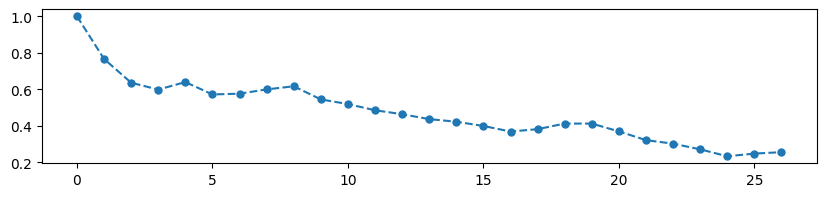

In [16]:
_, ax = plt.subplots(figsize=(10, 2))
ax.plot(acf(frac_beta_s), marker='o', linestyle='dashed', markersize=5)

In [17]:
storm_beta = frac_beta_s.iloc[np.where(frac_label == 1)]

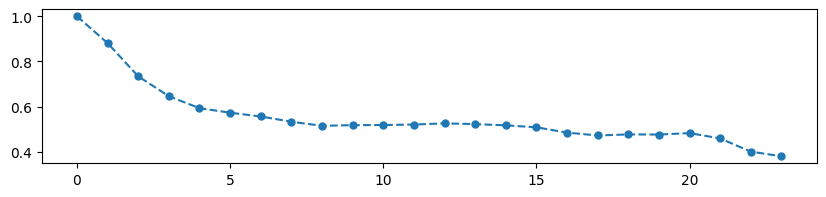

In [18]:
_, ax = plt.subplots(figsize=(10, 2))
ax.plot(acf(storm_beta), marker='o', linestyle='dashed', markersize=5)

In [19]:
no_events = turn_prediction_to_event_list(labels_train == 0)
len(no_events)

813

In [20]:
rng = np.random.RandomState(1)

n_events = 5
calm_events = rng.choice(no_events, n_events, replace=False)
storm_events = rng.choice(events, size=n_events, replace=False)
# calm_events, storm_events

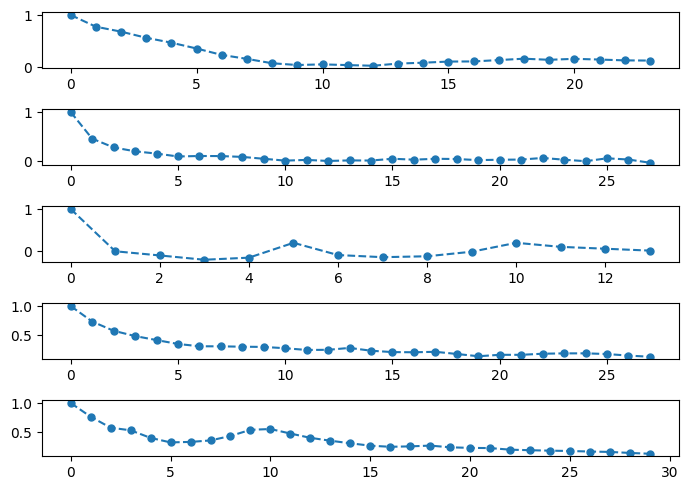

In [21]:
_, axs = plt.subplots(n_events, figsize=(7, 5))

for evt, ax in zip(calm_events, axs):
    beta_evt = thresh_beta_s.loc[evt.begin:evt.end]
    ax.plot(acf(beta_evt), marker='o', linestyle='dashed', markersize=5)
    
plt.tight_layout()    

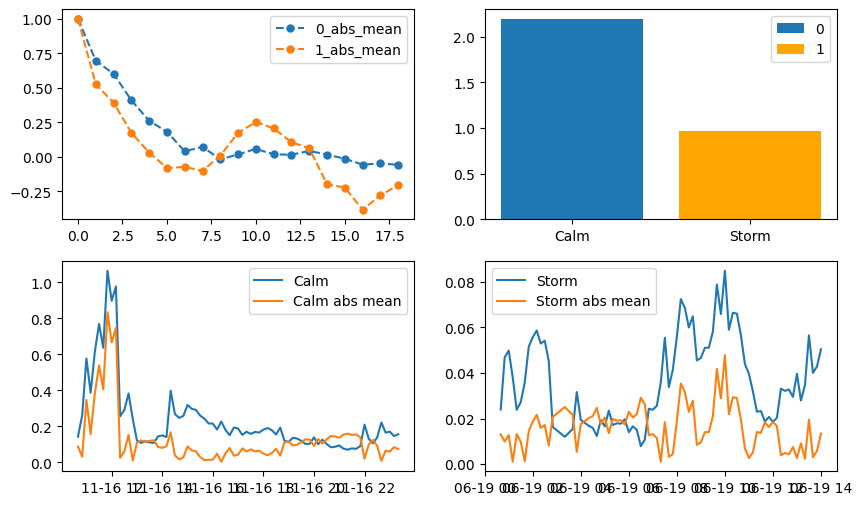

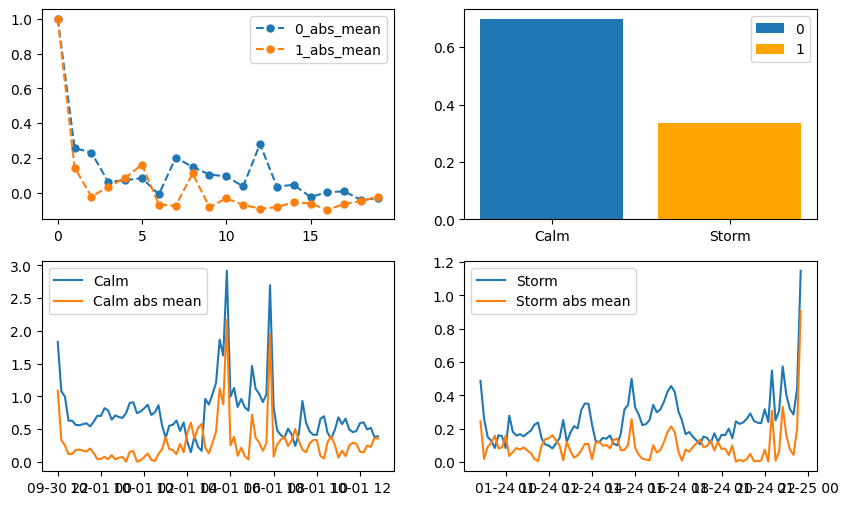

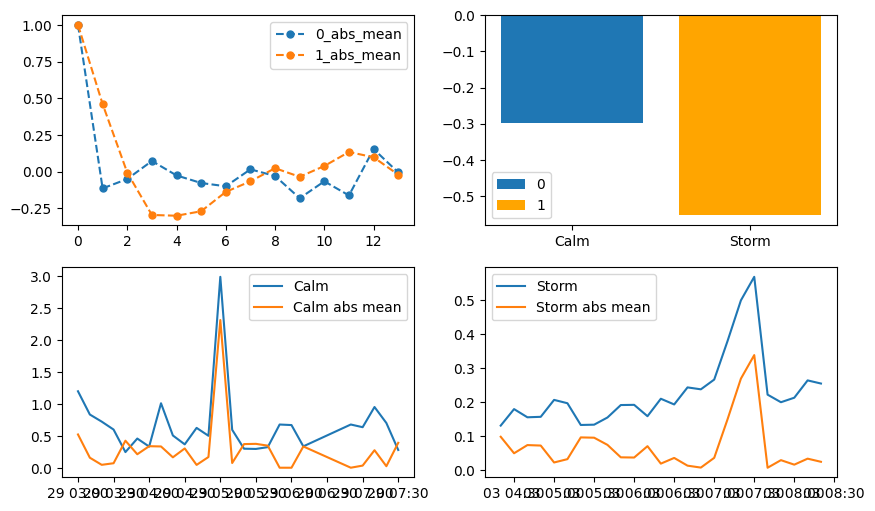

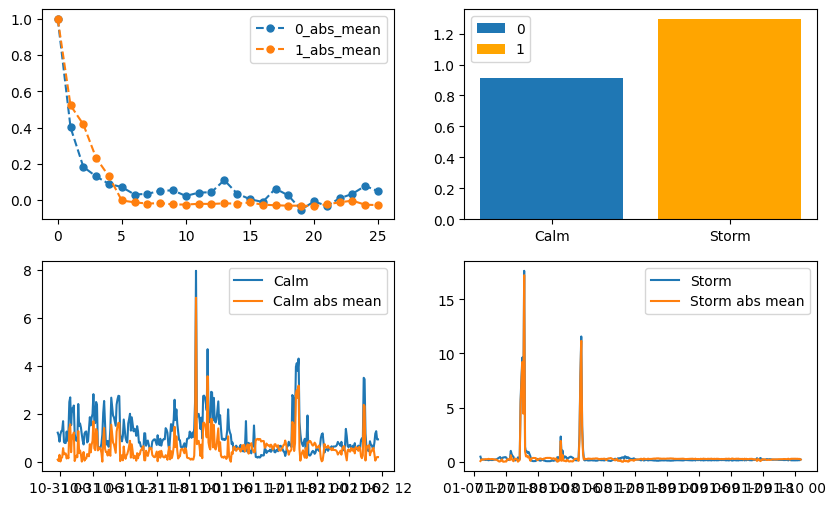

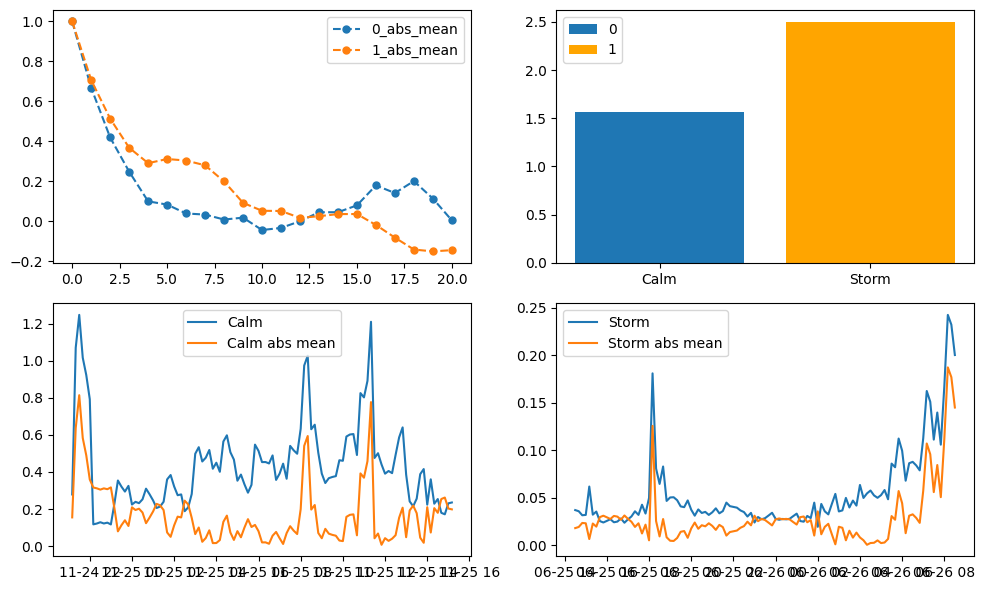

In [22]:
for calm_evt, storm_evt in zip(calm_events, storm_events):
    _ , ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

    beta_storm_evt = thresh_beta_s.loc[storm_evt.begin:storm_evt.end]
    beta_calm_evt = thresh_beta_s.loc[calm_evt.begin:calm_evt.end]

    min_duration = min(len(beta_calm_evt), len(beta_storm_evt))
    beta_calm_evt = beta_calm_evt.iloc[:min_duration]
    beta_storm_evt = beta_storm_evt.iloc[:min_duration]

    # Transformation
    beta_calm_abs_mean_evt = (beta_calm_evt - beta_calm_evt.mean()).abs()
    beta_storm_abs_mean_evt = (beta_storm_evt - beta_storm_evt.mean()).abs()

    # Coeff d'autocorrélation 
    n_corr_r = 6
    calm_acf, storm_acf = acf(beta_calm_abs_mean_evt), acf(beta_storm_abs_mean_evt)
    calm_acf_sum = np.sum(calm_acf[1:n_corr_r + 1])
    storm_acf_sum = np.sum(storm_acf[1:n_corr_r + 1])


    ax[0, 0].plot(calm_acf, marker='o', linestyle='dashed', markersize=5, label='0_abs_mean')
    ax[0, 0].plot(storm_acf, marker='o', linestyle='dashed', markersize=5, label='1_abs_mean')
    ax[0, 1].bar(['Calm', 'Storm'], [calm_acf_sum, storm_acf_sum], label=['0', '1'], color=['tab:blue', 'orange'])

    ax[1, 0].plot(beta_calm_evt, label='Calm')
    ax[1, 0].plot(beta_calm_abs_mean_evt, label='Calm abs mean')
    ax[1, 1].plot(beta_storm_evt, label='Storm')
    ax[1, 1].plot(beta_storm_abs_mean_evt, label='Storm abs mean')


    #ax.plot(acf(beta_calm_evt), marker='o', linestyle='dashed', markersize=5, label='0')
    #ax.plot(acf(beta_calm_mean_evt), marker='o', linestyle='dashed', markersize=5, label='0_mean')

    #ax.plot(acf(beta_storm_evt), marker='o', linestyle='dashed', color='orange', markersize=5, label='1_mean')
    #ax.plot(acf(beta_storm_mean_evt), marker='o', linestyle='dashed', markersize=5, label='1_mean')
    for a in ax.flatten():
        a.legend()

    
plt.tight_layout()    

Seuiller des valeurs lorsqu'elles s'écartent de trop de la valeurs moyenne
Classification sur beta : 
- Aire sous la courbe (de Beta directement)
- Aire sous la courbe de l'écart à la moyenne en |.| 
- Aire sous la courbe de l'écart à la moyenne en |.| avec écrasement des valeurs "trop éloignées" de la moyenne ?

Les coefficients d'autocorrélation ne semblent pas si indicateurs que ça hélas..

#### Tests de mesures

In [23]:
seuil = 50
var_s = data_train['Beta'].map(lambda x: min(x, seuil))
var_s = var_s.rolling('30 min', center=True).mean()

In [24]:
# Étude des évolutions avec les calculs d'écarts centrés
# Petite moyenne, grande moyenne, mean-ratio et écart type sur petite moyenne 

var_small_s = var_s.rolling('5 h', center=True).mean()
var_long_s = var_s.rolling('4 d', center=True).mean()

df = pd.DataFrame({})
df['no-mean'] = data_train['Beta'].copy() 
df['small_avg'] = var_small_s
df['global_avg'] = var_long_s

df['mean-ratio'] = df['small_avg'] / df['global_avg']
df['std'] = df['small_avg'].rolling('20 h', center=True).std()

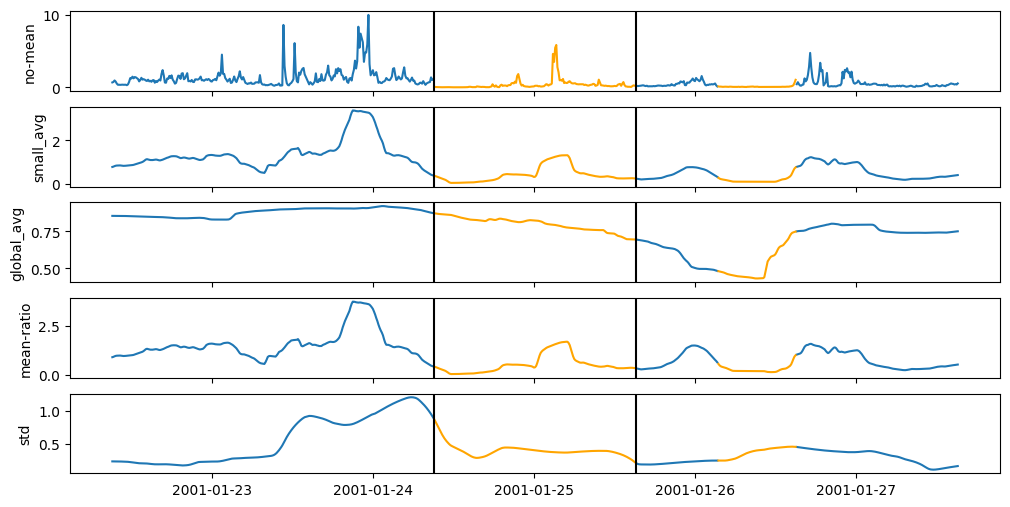

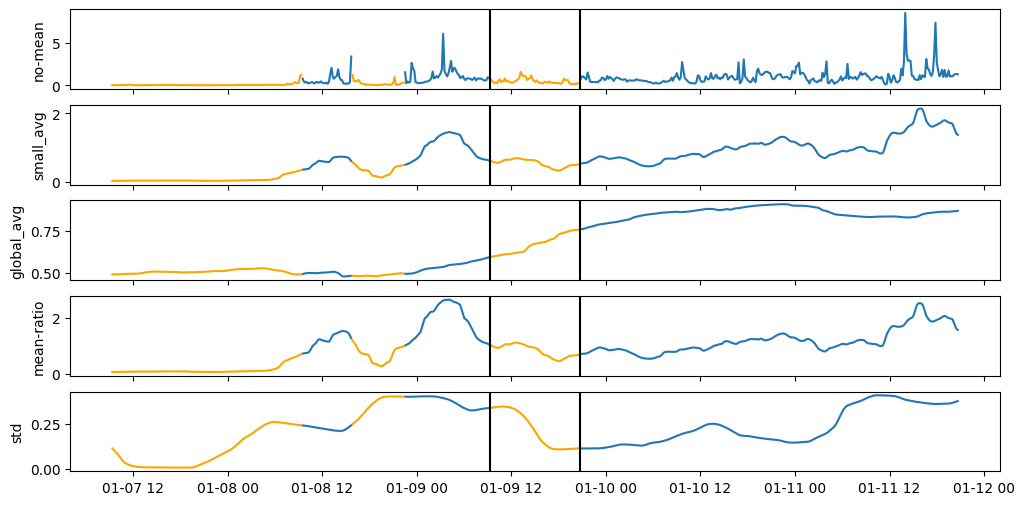

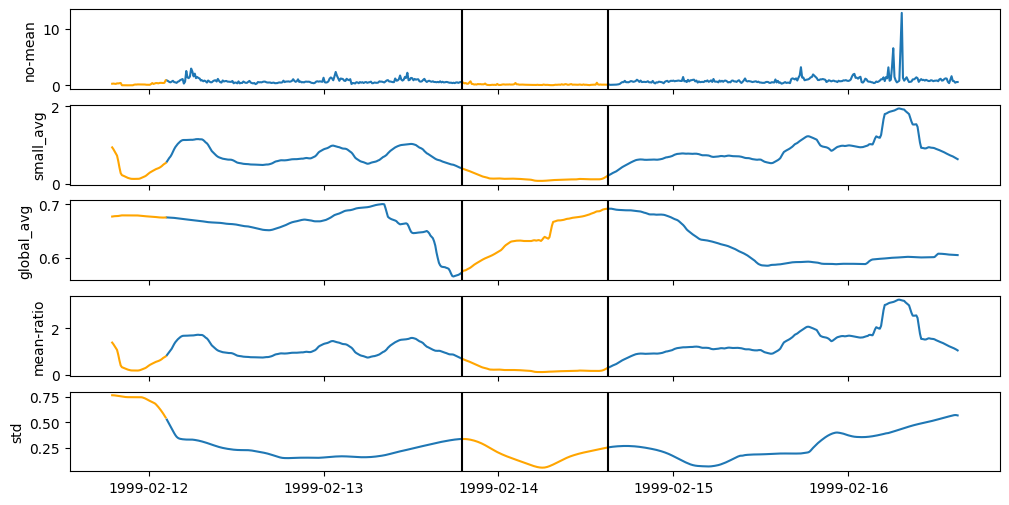

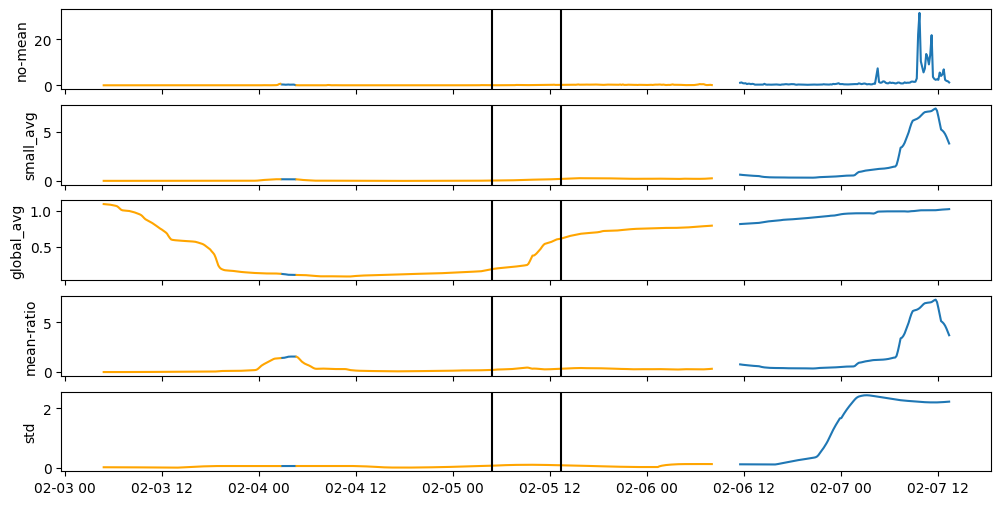

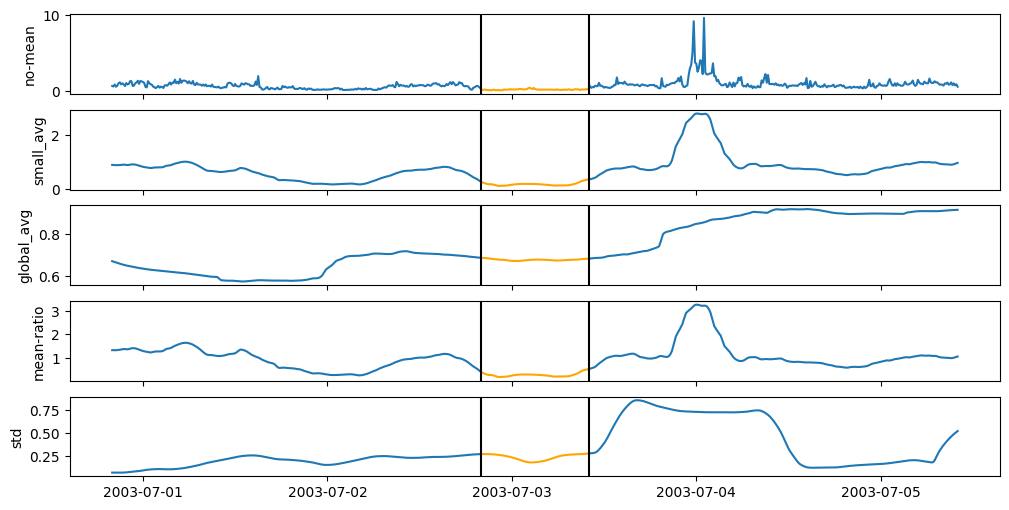

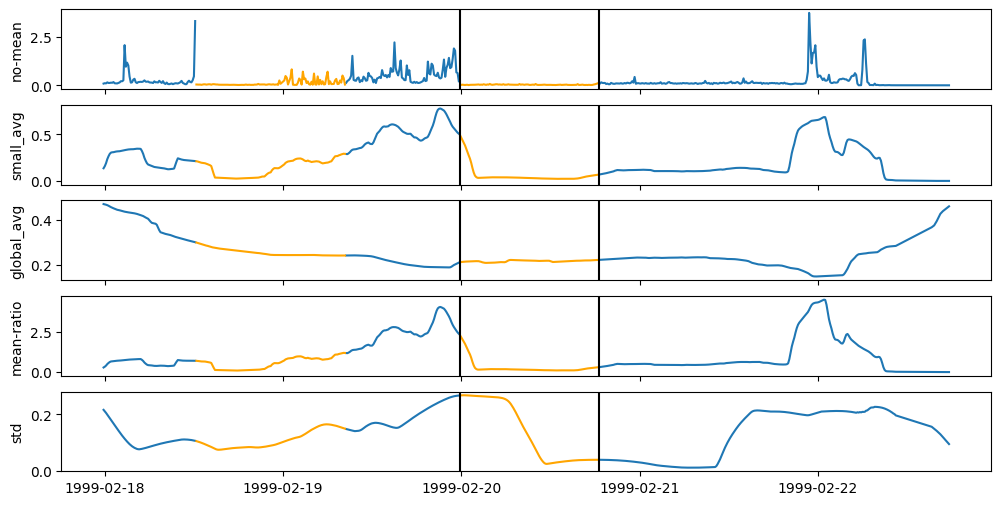

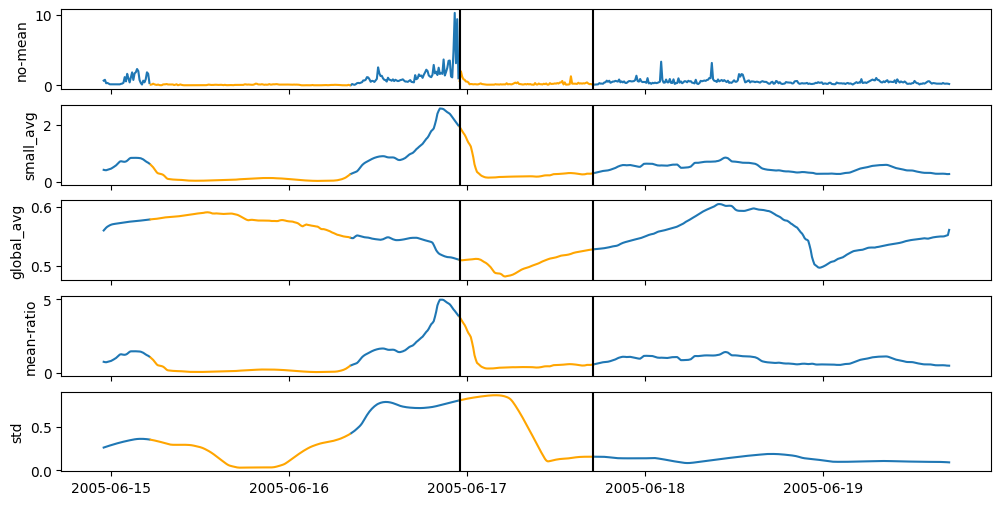

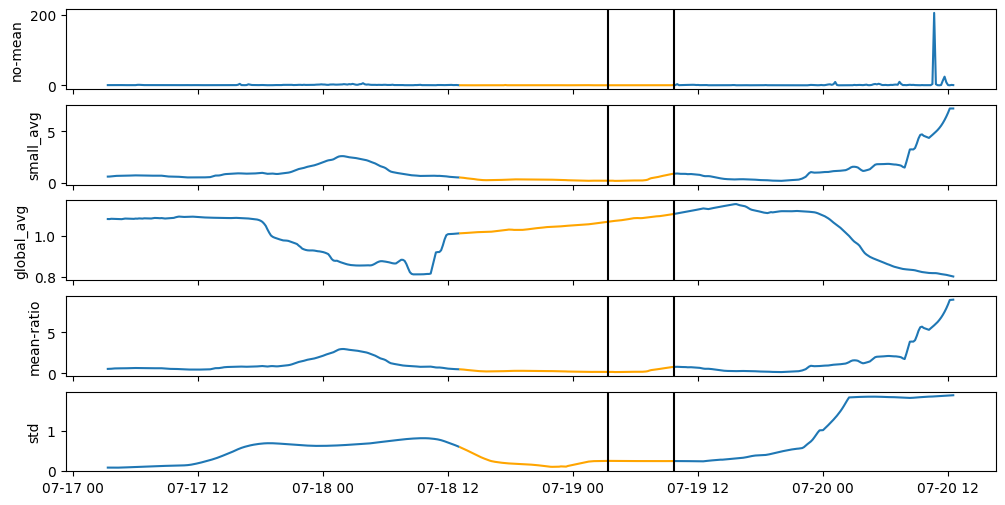

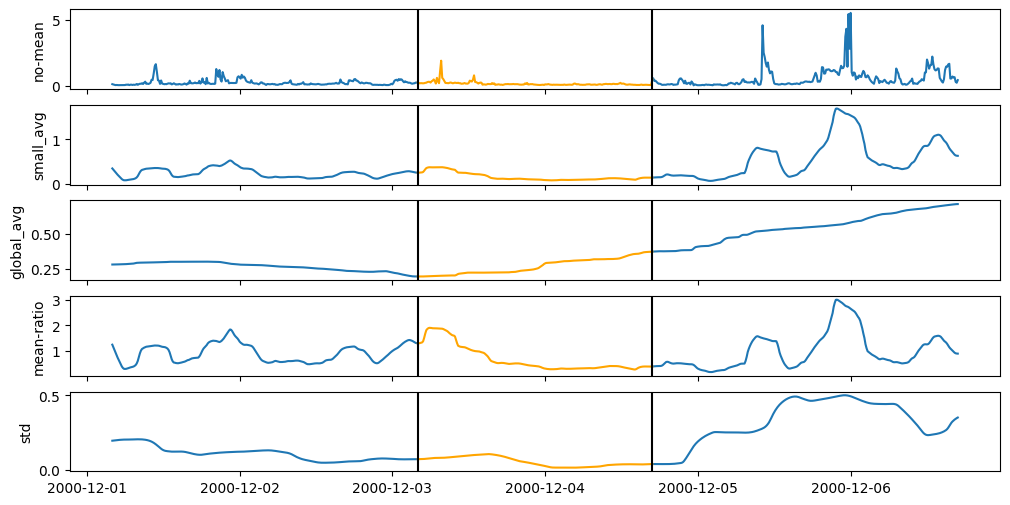

In [25]:
multiple_plots(
    df,
    labels_train,
    n_events=9,
    events=events,
    delta=48,
    random_state=2,
    figsize=(12, 6))

- Afficher les mêmes courbes avec la tendance gauche / droite 
- Petite moyenne mobile (5/6 valeurs & auto-corrélation des courbes)

In [26]:
seuil = 50
var_s = data_train['Beta'].map(lambda x: min(x, seuil))
var_s = var_s.rolling('30 min', center=True).mean()

In [27]:
var_small_s = var_s.rolling('4h', center=True).mean()
var_long_s = var_s.rolling('4 d', center=True).mean()

var_l_small_s = var_s.rolling('3h').mean()
var_r_small_s = var_s.iloc[::-1].rolling('3h').mean().iloc[::-1]

var_l_long_s = var_s.rolling('2 d').mean()
var_r_long_s = var_s.iloc[::-1].rolling('2 d').mean().iloc[::-1]

In [28]:
df = pd.DataFrame({})
df['base'] = var_s.copy() 

df['l_small_avg'] = var_l_small_s
df['r_small_avg'] = var_r_small_s

df['l_global_avg'] = var_l_long_s
df['r_global_avg'] = var_r_long_s

df['diff-mean'] = df['r_small_avg'] - df['l_small_avg']
df['mean-ratio'] = var_small_s / var_long_s # valeurs centrées

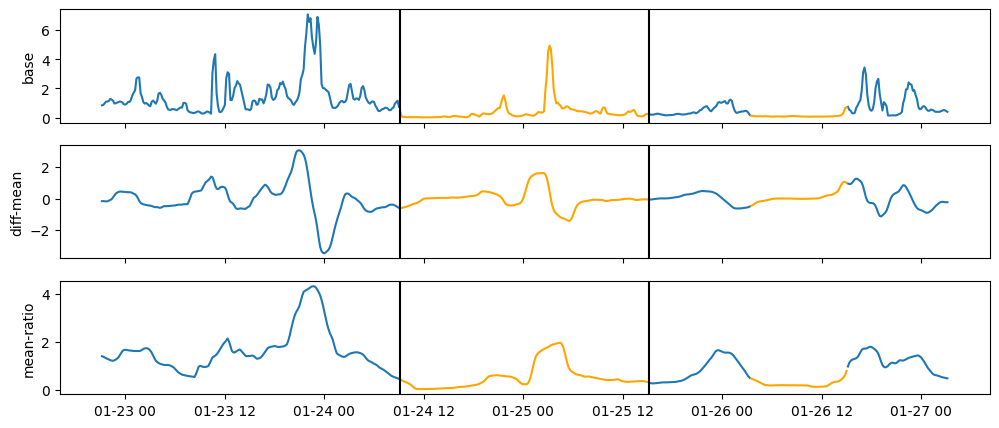

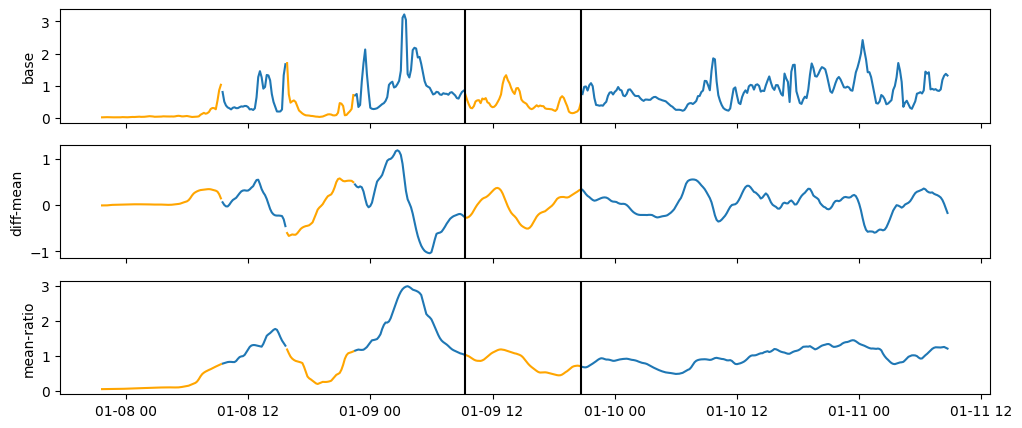

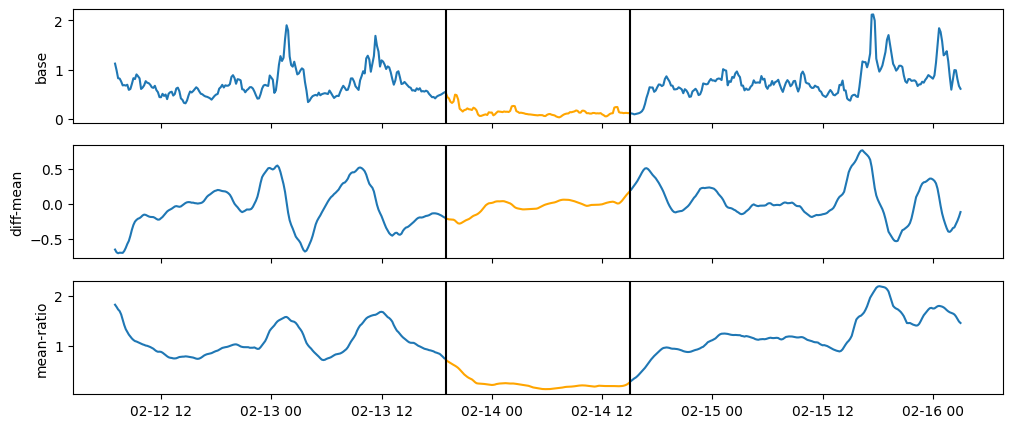

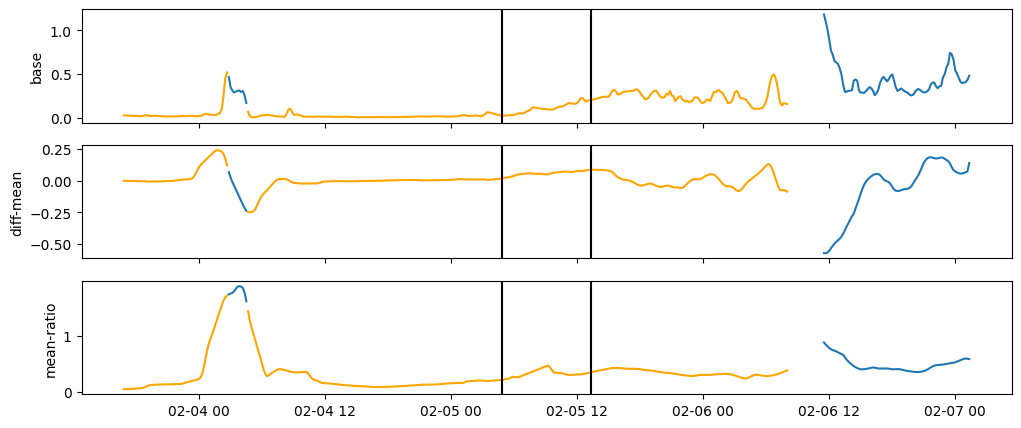

In [32]:
keept = ['base', 'diff-mean', 'mean-ratio']

# Events display
multiple_plots(
    df[keept],
    labels_train,
    n_events=4,
    events=events,
    delta=36,
    random_state=2,
    figsize=(12, 5))

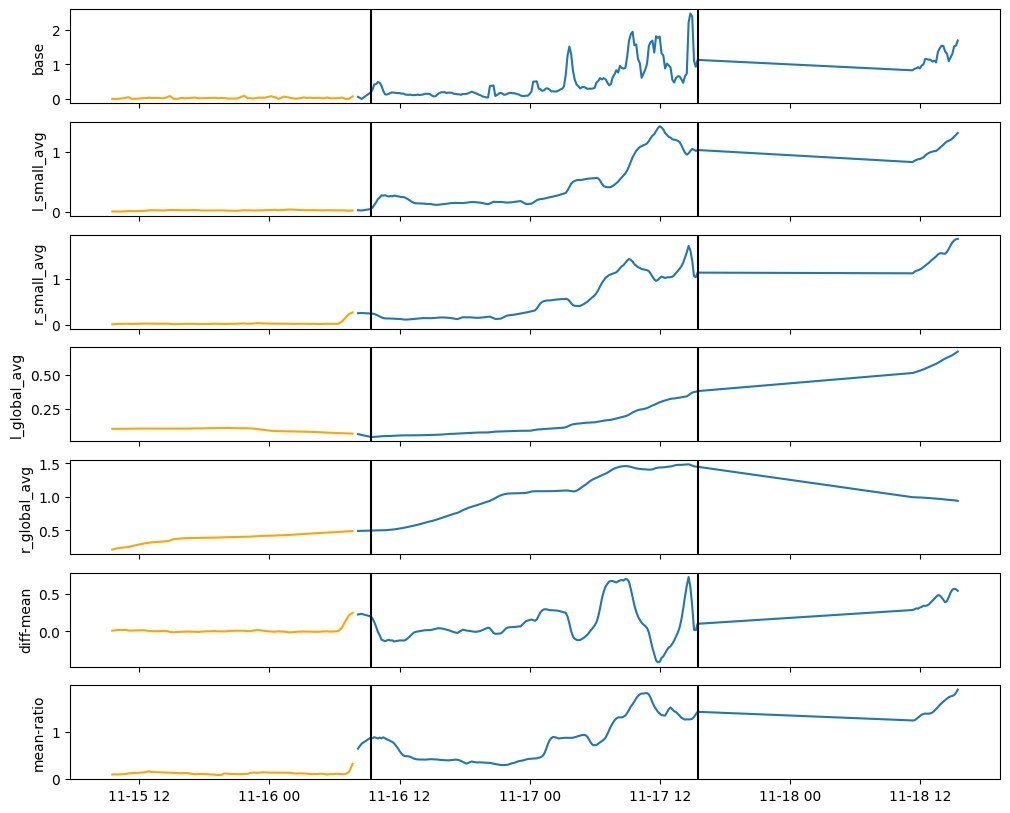

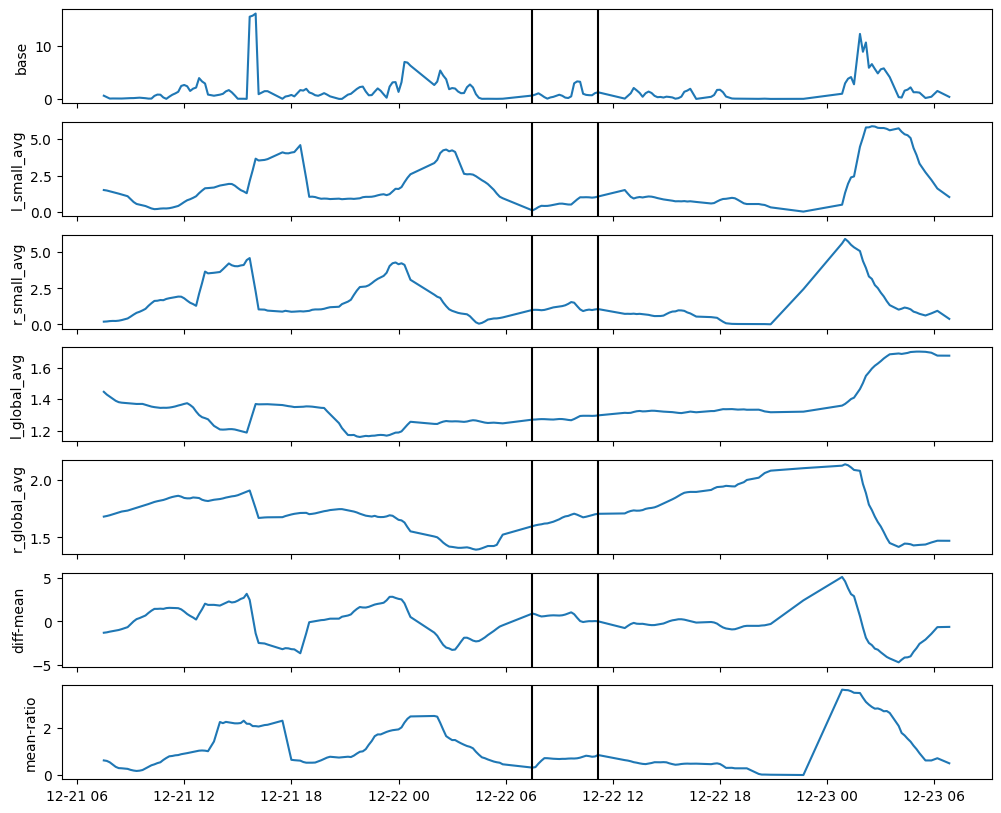

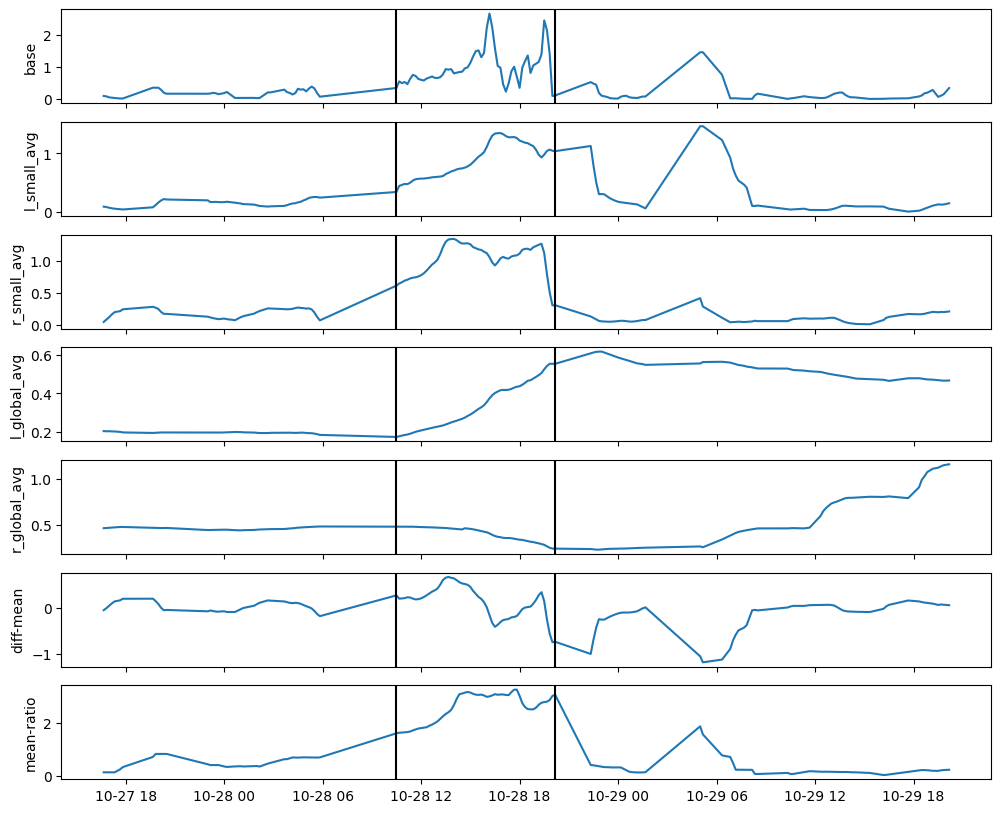

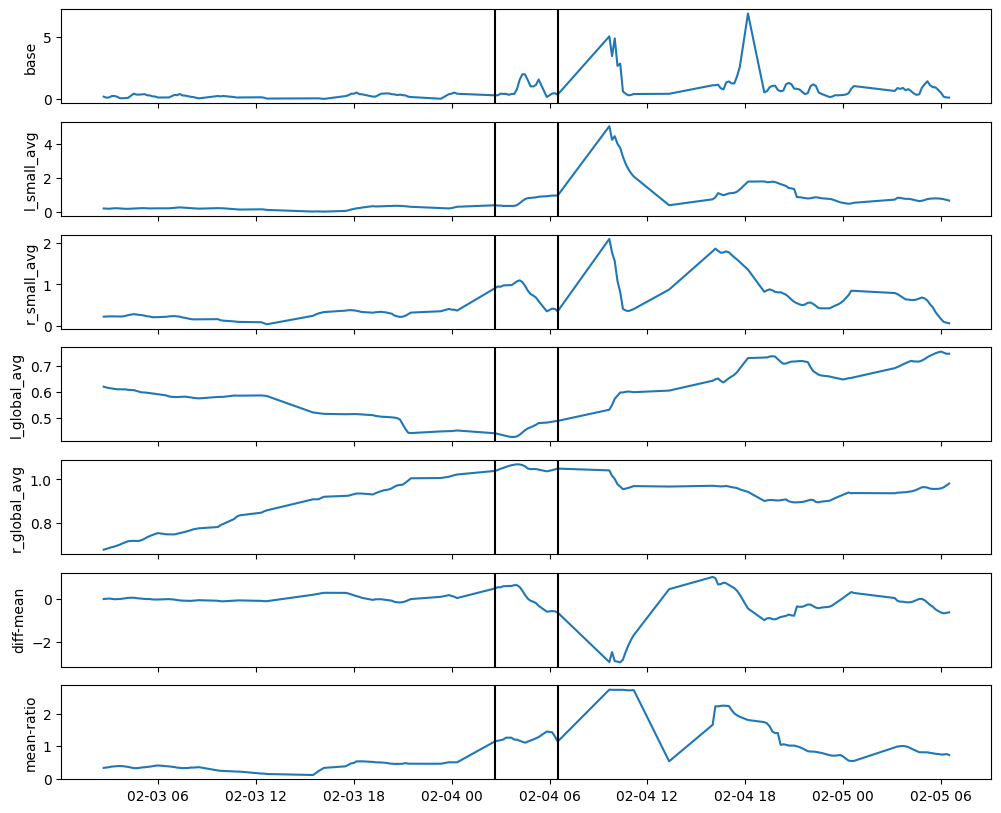

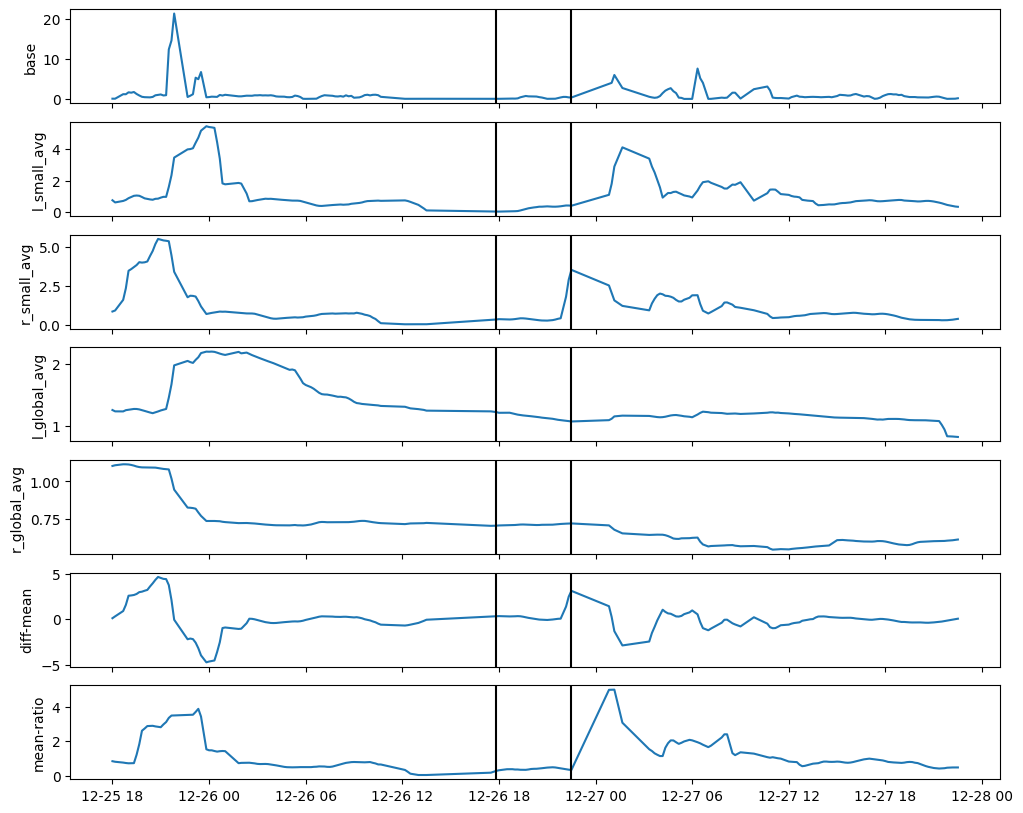

In [31]:
# No events display

multiple_plots(
    df,
    labels_train,
    n_events=5,
    events=no_events,
    delta=24,
    random_state=2,
    figsize=(12, 10))